1. 匯入套件

In [3]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from pathlib import Path

2. 設定檔案路徑

In [11]:
df_raw = pd.read_csv("nba_2425_stats.csv") 
print("原始資料筆數：", len(df_raw))
df_raw.head()

原始資料筆數： 736


,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Player-additional
0,1.0,Shai Gilgeous-Alexander,26.0,OKC,PG,76.0,76.0,34.2,11.3,21.8,...,4.1,5.0,6.4,1.7,1.0,2.4,2.2,32.7,MVP-1DPOY-10CPOY-8ASNBA1,gilgesh01
1,2.0,Giannis Antetokounmpo,30.0,MIL,PF,67.0,67.0,34.2,11.8,19.7,...,9.7,11.9,6.5,0.9,1.2,3.1,2.3,30.4,MVP-3DPOY-8ASNBA1,antetgi01
2,3.0,Nikola Jokić,29.0,DEN,C,70.0,70.0,36.7,11.2,19.5,...,9.9,12.7,10.2,1.8,0.6,3.3,2.3,29.6,MVP-2CPOY-2ASNBA1,jokicni01
3,4.0,Luka Dončić,25.0,2TM,PG,50.0,50.0,35.4,9.2,20.5,...,7.4,8.2,7.7,1.8,0.4,3.6,2.5,28.2,NaN,doncilu01
4,4.0,Luka Dončić,25.0,DAL,PG,22.0,22.0,35.7,9.8,21.2,...,7.6,8.3,7.8,2.0,0.4,3.4,2.6,28.1,NaN,doncilu01


3. Transform: 傳統九項

In [12]:
# 選欄位
fantasy_cols = [
    "Player", "Team", "PTS", "TRB", "AST", "STL", "BLK", "3P", "FG%", "FT%", "TOV"
]

df_fantasy = df_raw[fantasy_cols].copy()

# 欄位標準化（改小寫+底線）
df_fantasy.columns = [c.lower().replace("%", "_pct") for c in df_fantasy.columns]

# 確保數值欄位是 float
num_cols = [c for c in df_fantasy.columns if c not in ["player", "team"]]
for col in num_cols:
    df_fantasy[col] = pd.to_numeric(df_fantasy[col], errors="coerce")

df_fantasy.head()

,player,team,pts,trb,ast,stl,blk,3p,fg_pct,ft_pct,tov
0,Shai Gilgeous-Alexander,OKC,32.7,5.0,6.4,1.7,1.0,2.1,0.519,0.898,2.4
1,Giannis Antetokounmpo,MIL,30.4,11.9,6.5,0.9,1.2,0.2,0.601,0.617,3.1
2,Nikola Jokić,DEN,29.6,12.7,10.2,1.8,0.6,2.0,0.576,0.800,3.3
3,Luka Dončić,2TM,28.2,8.2,7.7,1.8,0.4,3.5,0.450,0.782,3.6
4,Luka Dončić,DAL,28.1,8.3,7.8,2.0,0.4,3.4,0.464,0.767,3.4


In [17]:
import numpy as np

# --- 1) 定義打分工具 ---
def tier_score(x, rules_desc):
    """
    rules_desc: list[(threshold, score)]，由高到低排列，遇到第一個符合的門檻就回傳分數
    例：[(25,3), (20,2), (15,1)]
    """
    if pd.isna(x): 
        return 0
    for thr, s in rules_desc:
        if x >= thr:
            return s
    return 0

def tier_score_low_is_better(x, rules_asc):
    """
    低越好（例如 TOV 失誤）用這個。rules_asc: list[(max_threshold, score)] 由低到高排
    例：[(1.5,3), (2.5,2), (3.0,1)]
    """
    if pd.isna(x):
        return 0
    for thr, s in rules_asc:
        if x <= thr:
            return s
    return 0

# --- 2) 你的初版規則（可隨時改） ---
R_POINTS = [(25,3), (20,2), (15,1)]
R_3P     = [(2.5,3), (2,2), (1.5,1)]
R_REB    = [(10,3), (7,2), (5,1)]
R_AST    = [(8,3), (5,2), (3,1)]
R_STL    = [(1.5,4), (1.2,2), (1,1)]
R_BLK    = [(1.5,4), (1.2,2), (1,1)]
# 你前面舉例 FG% 門檻寫法有點矛盾，我先給一組合理的：0.50 / 0.47 / 0.44
R_FG     = [(0.50,3), (0.47,2), (0.44,1)]
# 罰球照你提的：>0.85=3 >0.8=2 >0.75=1
R_FT     = [(0.85,3), (0.80,2), (0.75,1)]
# 失誤越少越好
R_TOV    = [(1,3), (1.5,2), (2,1)]  # <=1.5 得3分, <=2.5 得2分, <=3.0 得1分

# --- 3) 保險：確保數值欄位都是 numeric ---
for c in ["pts","3p","trb","ast","stl","blk","fg_pct","ft_pct","tov"]:
    if c in df_fantasy.columns:
        df_fantasy[c] = pd.to_numeric(df_fantasy[c], errors="coerce")

# --- 4) 逐項計分 ---
df_fantasy["score_pts"] = df_fantasy["pts"].apply(lambda x: tier_score(x, R_POINTS))
df_fantasy["score_3p"]  = df_fantasy["3p"].apply(lambda x: tier_score(x, R_3P))
df_fantasy["score_trb"] = df_fantasy["trb"].apply(lambda x: tier_score(x, R_REB))
df_fantasy["score_ast"] = df_fantasy["ast"].apply(lambda x: tier_score(x, R_AST))
df_fantasy["score_stl"] = df_fantasy["stl"].apply(lambda x: tier_score(x, R_STL))
df_fantasy["score_blk"] = df_fantasy["blk"].apply(lambda x: tier_score(x, R_BLK))
df_fantasy["score_fg"]  = df_fantasy["fg_pct"].apply(lambda x: tier_score(x, R_FG))
df_fantasy["score_ft"]  = df_fantasy["ft_pct"].apply(lambda x: tier_score(x, R_FT))
df_fantasy["score_tov"] = df_fantasy["tov"].apply(lambda x: tier_score_low_is_better(x, R_TOV))

# --- 5) 加總成 FB points ---
score_cols = [c for c in df_fantasy.columns if c.startswith("score_")]
df_fantasy["fb_points"] = df_fantasy[score_cols].sum(axis=1)

# 看前幾名
df_fantasy.sort_values("fb_points", ascending=False)[
    ["player","team","fb_points"] + score_cols
].head(15)

,player,team,fb_points,score_pts,score_3p,score_trb,score_ast,score_stl,score_blk,score_fg,score_ft,score_tov
2,Nikola Jokić,DEN,20,3,2,3,3,4,0,3,2,0
0,Shai Gilgeous-Alexander,OKC,19,3,2,1,2,4,1,3,3,0
24,Victor Wembanyama,SAS,18,2,3,3,1,1,4,2,2,0
17,Anthony Davis,LAL,17,3,0,3,1,2,4,3,1,0
16,Anthony Davis,2TM,16,2,0,3,1,2,4,3,1,0
38,James Harden,LAC,16,2,3,1,3,4,0,0,3,0
3,Luka Dončić,2TM,16,3,3,2,2,4,0,1,1,0
4,Luka Dončić,DAL,16,3,3,2,2,4,0,1,1,0
84,Jimmy Butler,GSW,15,1,0,1,2,4,0,2,3,2
45,Kawhi Leonard,LAC,15,2,2,1,1,4,0,2,2,1


4. Load: SQL Lite

In [18]:
from sqlalchemy import create_engine

# 假設你已經有 df_fantasy（含 fb_points）
engine = create_engine("sqlite:///nba.db", future=True)

# 原始表 & 轉換表都存一下（可視需要留一個就好）
df_raw.to_sql("player_stats_raw", engine, if_exists="replace", index=False)
df_fantasy.to_sql("player_stats_fantasy", engine, if_exists="replace", index=False)

print("✅ 已寫入本地 SQLite → nba.db")


✅ 已寫入本地 SQLite → nba.db


In [23]:
import pandas as pd
from sqlalchemy import text  # 👈 新增

q = """
SELECT player, team, pts, "3p", trb, ast, stl, blk, fg_pct, ft_pct, tov, fb_points
FROM player_stats_fantasy
ORDER BY fb_points DESC
LIMIT 20
"""

# SQLAlchemy 2.0 正確用法：用 connect()，並把字串 SQL 包進 text()
with engine.connect() as conn:
    top20 = pd.read_sql(text(q), conn)   # 👈 這裡用 text(q)

top20.head()

,player,team,pts,3p,trb,ast,stl,blk,fg_pct,ft_pct,tov,fb_points
0,Nikola Jokić,DEN,29.6,2.0,12.7,10.2,1.8,0.6,0.576,0.800,3.3,20
1,Shai Gilgeous-Alexander,OKC,32.7,2.1,5.0,6.4,1.7,1.0,0.519,0.898,2.4,19
2,Victor Wembanyama,SAS,24.3,3.1,11.0,3.7,1.1,3.8,0.476,0.836,3.2,18
3,Anthony Davis,LAL,25.7,0.7,11.9,3.4,1.3,2.1,0.528,0.788,2.2,17
4,Luka Dončić,2TM,28.2,3.5,8.2,7.7,1.8,0.4,0.450,0.782,3.6,16


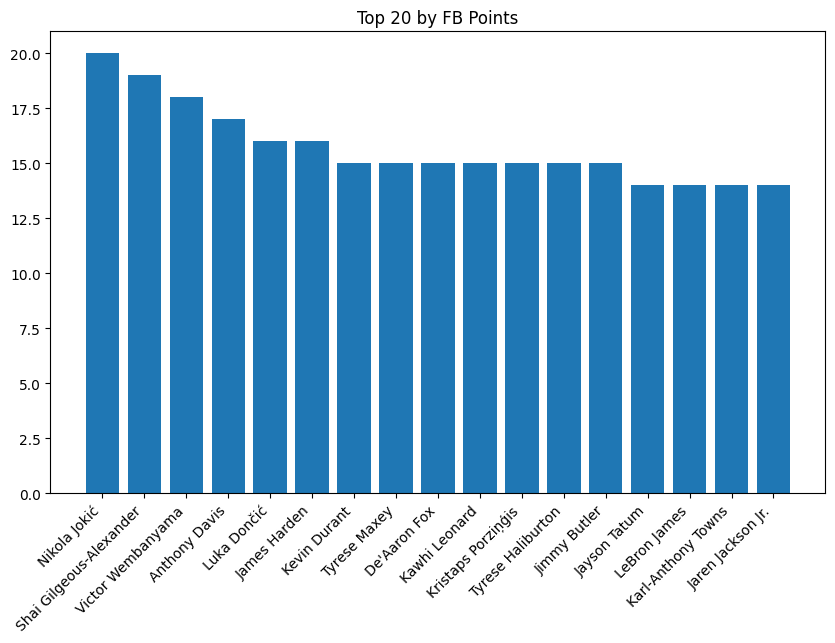

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(top20["player"], top20["fb_points"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 by FB Points")
plt.show()

In [1]:
import sqlite3
import pandas as pd

# 連線到 SQLite 資料庫
conn = sqlite3.connect("nba.db")

# 列出所有資料表
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("📌 資料庫裡的資料表：")
print(tables)

# 檢查 player_stats_raw 前 5 筆
print("\n📊 player_stats_raw：")
print(pd.read_sql("SELECT * FROM player_stats_raw LIMIT 5;", conn))

# 檢查 player_stats_fantasy 前 5 筆
print("\n📊 player_stats_fantasy：")
print(pd.read_sql("SELECT * FROM player_stats_fantasy LIMIT 5;", conn))

conn.close()


📌 資料庫裡的資料表：
                   name
0      player_stats_raw
1  player_stats_fantasy

📊 player_stats_raw：
    Rk                   Player   Age Team Pos     G    GS    MP    FG   FGA  \
0  1.0  Shai Gilgeous-Alexander  26.0  OKC  PG  76.0  76.0  34.2  11.3  21.8   
1  2.0    Giannis Antetokounmpo  30.0  MIL  PF  67.0  67.0  34.2  11.8  19.7   
2  3.0             Nikola Jokić  29.0  DEN   C  70.0  70.0  36.7  11.2  19.5   
3  4.0              Luka Dončić  25.0  2TM  PG  50.0  50.0  35.4   9.2  20.5   
4  4.0              Luka Dončić  25.0  DAL  PG  22.0  22.0  35.7   9.8  21.2   

   ...  DRB   TRB   AST  STL  BLK  TOV   PF   PTS                    Awards  \
0  ...  4.1   5.0   6.4  1.7  1.0  2.4  2.2  32.7  MVP-1DPOY-10CPOY-8ASNBA1   
1  ...  9.7  11.9   6.5  0.9  1.2  3.1  2.3  30.4         MVP-3DPOY-8ASNBA1   
2  ...  9.9  12.7  10.2  1.8  0.6  3.3  2.3  29.6         MVP-2CPOY-2ASNBA1   
3  ...  7.4   8.2   7.7  1.8  0.4  3.6  2.5  28.2                      None   
4  ...  7.6   8.3  